In [1]:
# -------------------------------------------------------------------------
# Feb 26, 2024 Created
# Team: YNKuoJLien
# Code creator: Yan-Ning Kuo (yk545@cornell.edu)
#
# ForceSMIP_main_LIMnMCA_YNKuoJLien.ipynb is the main script to prepare
# the forced response estimate from group YNKuoJLien with LIMnMCA - a 
# combination of a Linear Inverse Model and Maximum Covariance Analysis
# (MCA).
# 
# -------------------------------------------------------------------------

In [1]:
## Importing necessary libraries
from os import walk
import glob
import re
import numpy as np
import xarray as xr
import xcat as xc
import time as clocktime
import netCDF4 as nc

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import sys
import import_ipynb
from ForceSMIP_function_ColorLIMnMCA_YNKuoJLien import *

importing Jupyter notebook from ForceSMIP_function_ColorLIMnMCA_YNKuoJLien.ipynb


/glade/derecho/scratch/kuoyan/tmp/ipykernel_66420/204199400.py:27: RuntimeWarning: invalid value encountered in multiply
  LDM = np.empty((len(fname),len(T),pcnum)) * np.nan


0
(876, 72, 144)
1
(876, 72, 144)
2
(876, 72, 144)
3
(876, 72, 144)
4
(876, 72, 144)
5
(876, 72, 144)
6
(876, 72, 144)
7
(876, 72, 144)
8
(876, 72, 144)
9
(876, 72, 144)


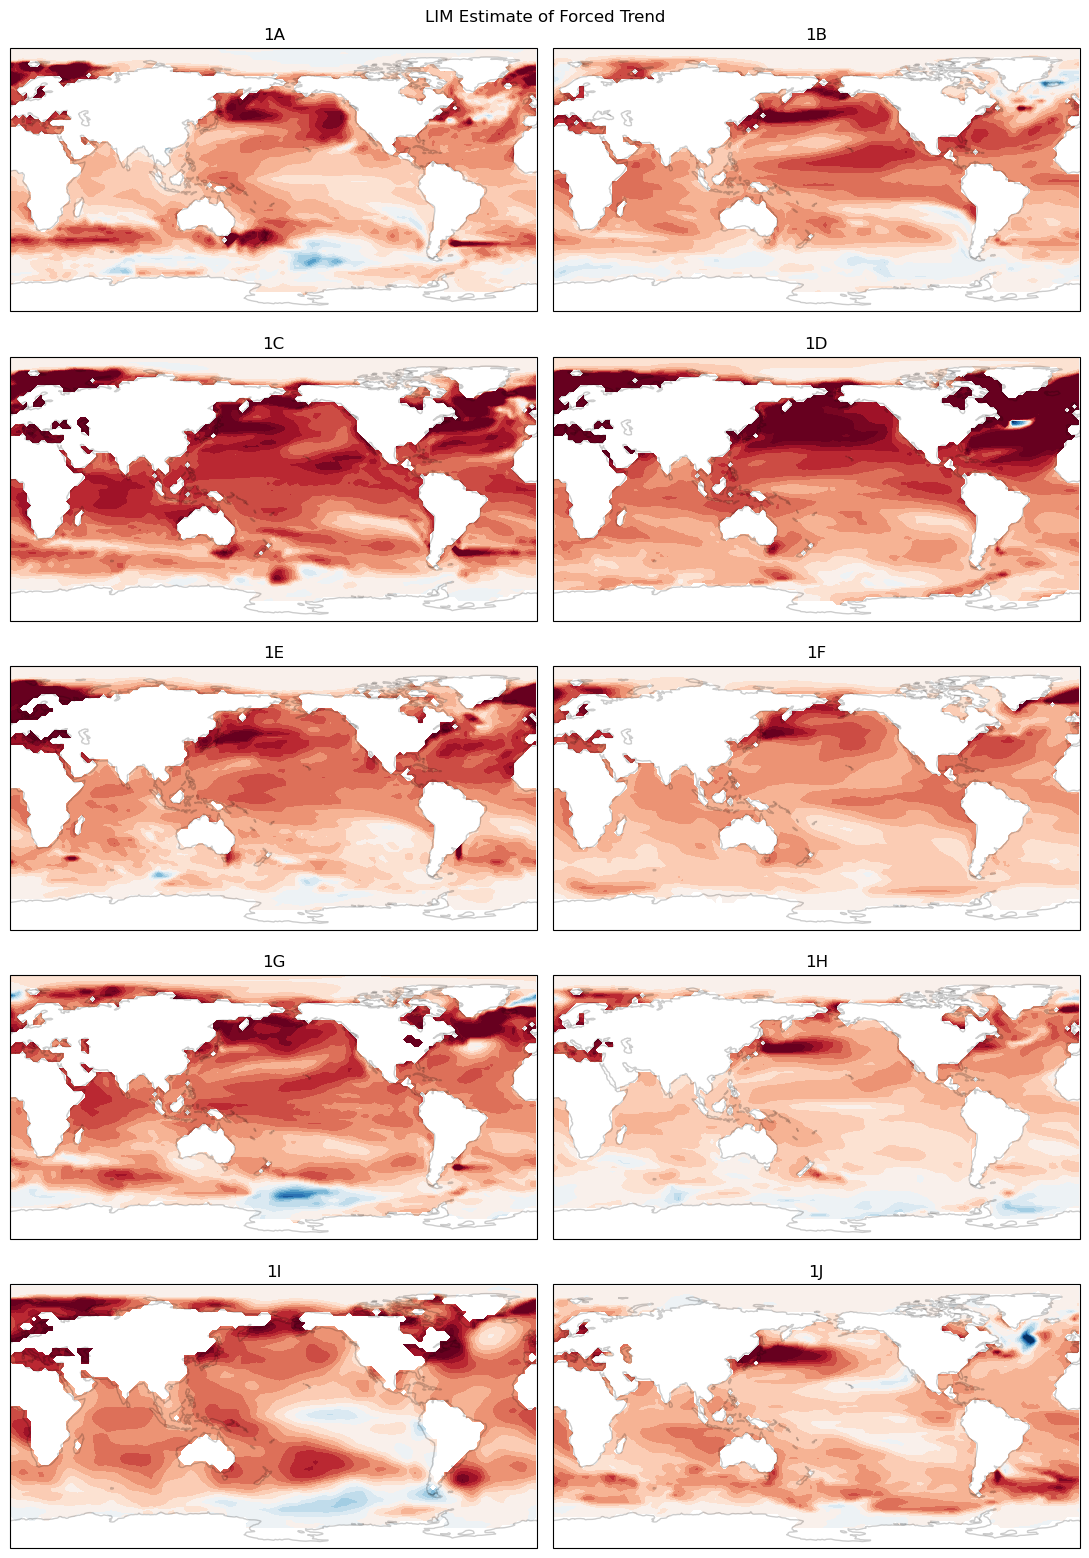

Text(0.5, 1.0, 'Forced tos (Global Mean)')

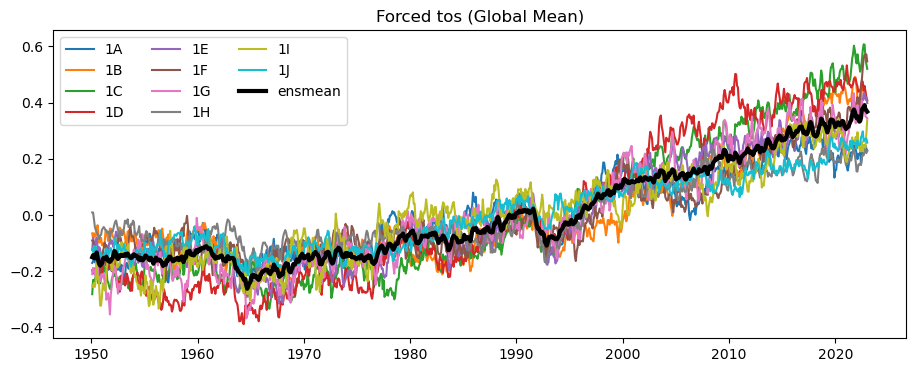

In [2]:

# -----To be Change-----
varname = "tos" # climate field of interest
root_dir = "/glade/campaign/cgd/cas/asphilli/ForceSMIP/Evaluation-Tier1/Omon/"+varname+"/"  # path to forcesmip data (NCAR)
fname = []
for (dirpath, dirnames, fnames) in walk(root_dir):
        fname.extend(fnames)
        break
fname.sort()
savepath = '/glade/derecho/scratch/kuoyan/ForceSMIP/Tier1/Omon/'+varname+'/'
# ----------------------
DD = nc.Dataset(root_dir+fname[0])
T4fw = DD['time'][:]
DD.close()
### Teir 1
data = ForceSMIP_read(root_dir+fname[0],varname)
lon_axis = data["lon_axis"]; lat_axis = data["lat_axis"]
weight = np.zeros((1,len(lat_axis),1))
weight[0,:,0] = np.cos(lat_axis*np.pi/180.)
TT = data["time"]
T = np.empty((len(TT),)) * np.nan
T[:] = TT.dt.year+TT.dt.month/12
pcnum = 9 # EOF truncation relevant to LIM (how many EOFs are kept?)

ensname = ["1A","1B","1C","1D","1E","1F","1G","1H","1I","1J"]
X_forced = np.empty((len(fname),72,144)) * np.nan
X_forced_glo = np.empty((len(fname),len(T))) * np.nan
LDM = np.empty((len(fname),len(T),pcnum)) * np.nan
# READ data
for i  in range(10):
    print(i)
    stime = clocktime.time()
    data = ForceSMIP_read(root_dir+fname[i],varname)
    # REMOVE SEASONAL MEAN
    data["seas"],data["ano"] = ForceSMIP_removeSeas(data[varname],data["time"])

    # EOF ANALYSIS
    data2D = ForceSMIP_XYT_into_ZT(data["ano"],data["mask"])
    pca = ForceSMIP_EOF((data2D-np.mean(data2D))*ForceSMIP_XYT_into_ZT(np.tile(weight,(len(T),1,len(lon_axis))),data["mask"]))

    # LIM based trend estimate
    # Note: for multiple variables, we typically construct a state vector X that consists of the leading 
    # PCs of all variables.
    X = pca["PC"][:,0:pcnum] # transpose into a format of [mode, time]
    X_least_damped = ForceSMIP_lim_trend(X.T, 1)
    Xtrd = ((X_least_damped).T @ np.diag(pca["S"][0:pcnum]**2) @ pca["EOF"][0:pcnum,:]*pca["norm"])
    LDM[i,:,:] = (X_least_damped).T
    X_forced_glo[i,:] = np.mean(Xtrd,1)
    X_forced[i,:,:] = ForceSMIP_ZT_into_XYT(lintrd(T,Xtrd/ForceSMIP_XYT_into_ZT(np.tile(weight,(len(T),1,len(lon_axis))),data["mask"]))[0], data["mask"])
    Xsave = ForceSMIP_ZT_into_XYT(Xtrd/ForceSMIP_XYT_into_ZT(np.tile(weight,(len(T),1,len(lon_axis))),data["mask"]), data["mask"])
    print(Xsave.shape)
    del X, pca, data2D, data, Xtrd, X_least_damped
    fw = varname+'_'+ensname[i]+'_tier1_LIMnMCA_YNKuoJLien.nc'
    ncfile = nc.Dataset(savepath+fw,'w', format='NETCDF4')
    lat_dim = ncfile.createDimension('lat', 72) # latitude axis
    lon_dim = ncfile.createDimension('lon', 144) # longitude axis
    time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
    lat = ncfile.createVariable('lat',np.double,('lat',))
    lat.units = 'degrees_north'
    lat.long_name = 'latitude'

    lon = ncfile.createVariable('lon', np.double, ('lon',))
    lon.units = 'degrees_east'
    lon.long_name = 'longitude'

    time = ncfile.createVariable('time', np.float64, ('time',))
    time.units = 'days since 1850-01-01'
    time.long_name = 'time'

    tos = ncfile.createVariable('tos', np.double,('time','lat','lon')) # note: unlimited dimension is leftmost
    tos.units = 'degC'
    tos.standard_name = 'LIM-estimated forced '+varname
    lon[:] = lon_axis
    lat[:] = lat_axis
    time[:] = T4fw
    tos[:,:,:] = Xsave
    ncfile.close()
    del Xsave

clevs = np.arange(-2, 2.2, 0.2) #*100

f = plt.figure(figsize=(11, 16))
for i in range(10):
    plt.subplot(5, 2, i+1, projection=ccrs.PlateCarree(central_longitude=-180))
    im = plt.contourf(lon_axis, lat_axis, X_forced[i,:,:]*73, clevs,\
        transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, extend='both')
    # coastlines
    plt.gca().set_global()
    plt.gca().coastlines(alpha=0.2)
    plt.title(ensname[i])
    #plt.title(eval_model)
plt.suptitle('LIM Estimate of Forced Trend')
plt.tight_layout()
plt.show()

f = plt.figure(figsize=(11, 4))
for i in range(10):
    plt.plot(T,X_forced_glo[i,:],label = ensname[i])
plt.plot(T, np.mean(X_forced_glo,0), linewidth = 3, color = 'k',label = 'ensmean')
plt.legend(ncol = 3)
plt.title('Forced '+varname+' (Global Mean)')


/glade/derecho/scratch/kuoyan/tmp/ipykernel_57812/3613334377.py:14: RuntimeWarning: invalid value encountered in multiply
  X_forced = np.empty((10,72,144)) * np.nan


tas_mon_1A.195001-202212.nc
tas_mon_1B.195001-202212.nc
tas_mon_1C.195001-202212.nc
tas_mon_1D.195001-202212.nc
tas_mon_1E.195001-202212.nc
tas_mon_1F.195001-202212.nc
tas_mon_1G.195001-202212.nc
tas_mon_1H.195001-202212.nc
tas_mon_1I.195001-202212.nc
tas_mon_1J.195001-202212.nc


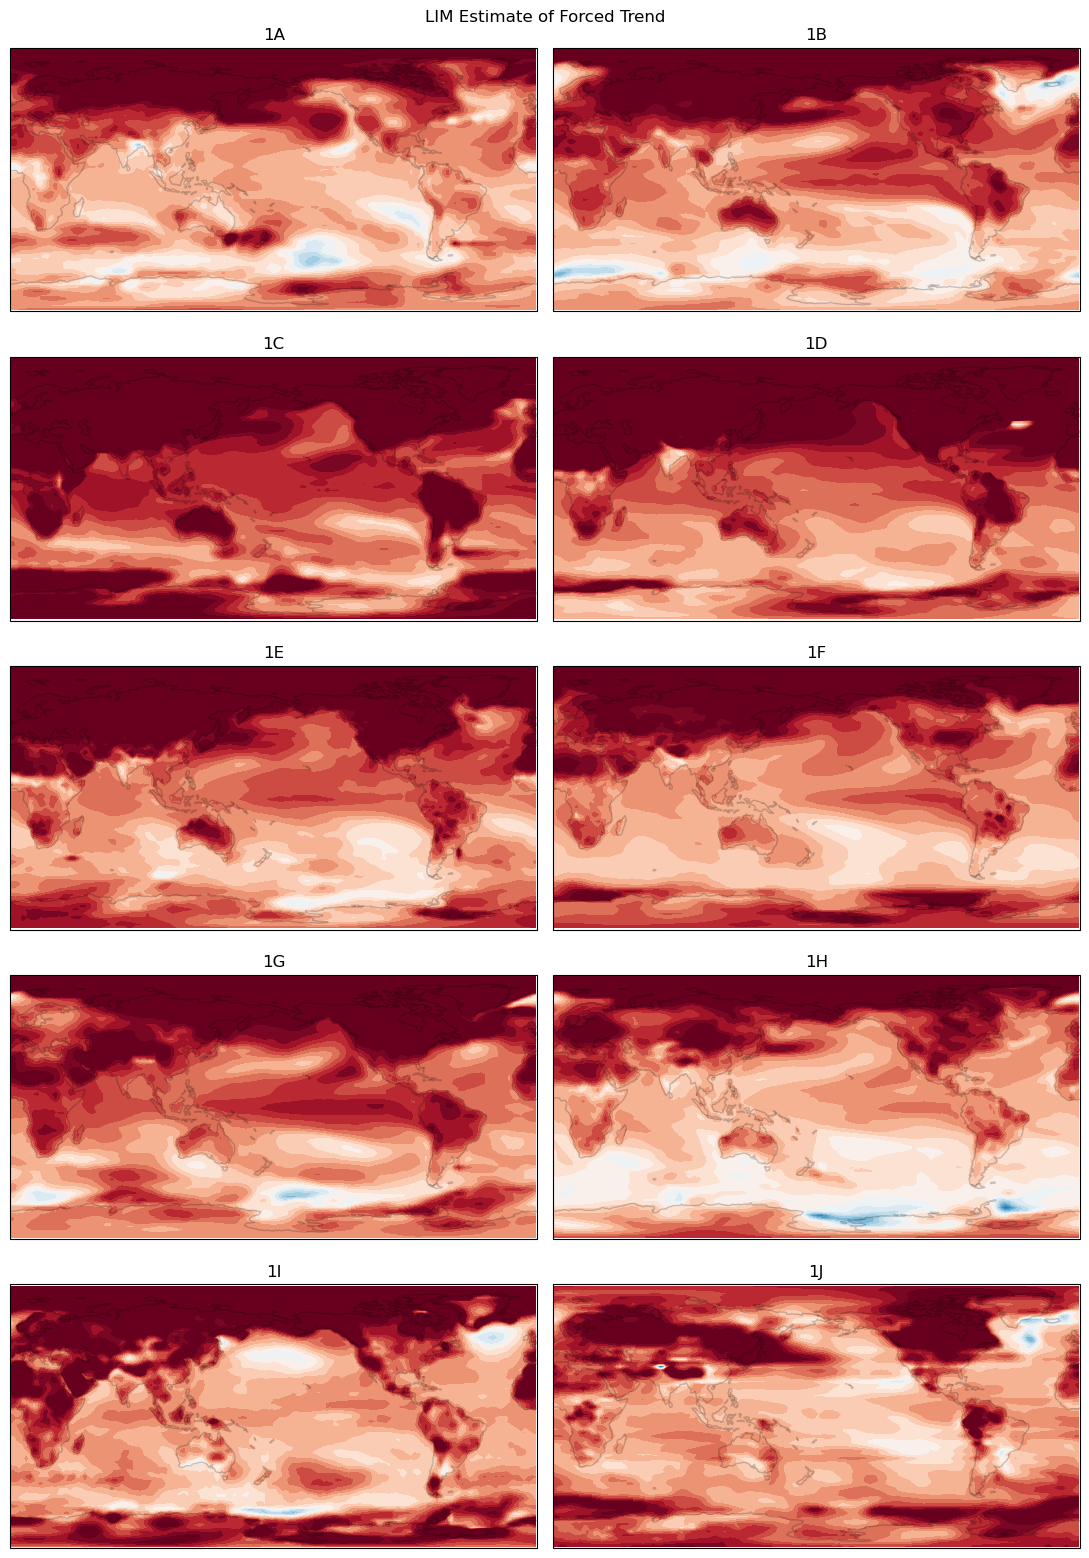

Text(0.5, 1.0, 'Forced tas (Global Mean)')

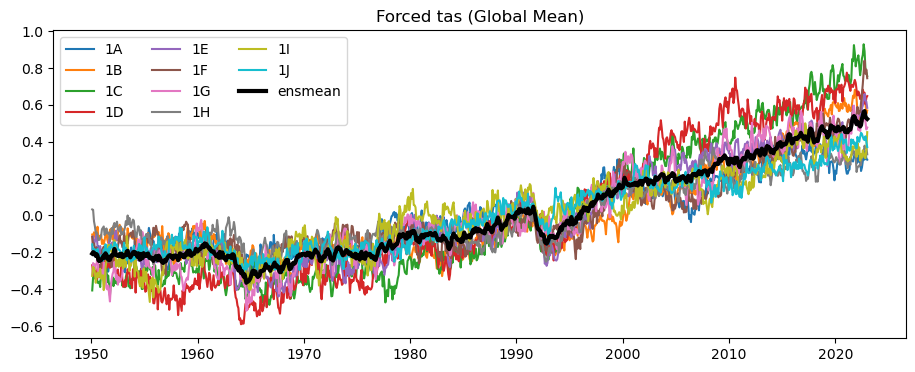

In [5]:
#####
## Target variable maxima covariance analysis [tas]
#####
# -----To be Change-----
varname = "tas" # climate field of interest
root_dir = "/glade/campaign/cgd/cas/asphilli/ForceSMIP/Evaluation-Tier1/Amon/"+varname+"/"  # path to forcesmip data (NCAR)
fname = []
for (dirpath, dirnames, fnames) in walk(root_dir):
        fname.extend(fnames)
        break
fname.sort()
savepath = '/glade/derecho/scratch/kuoyan/ForceSMIP/Tier1/Amon/'+varname+'/'

X_forced = np.empty((10,72,144)) * np.nan
X_forced_glo = np.empty((10,len(T))) * np.nan
for i in range(10):
    print(fname[i])
    ### Reading target variable
    data = ForceSMIP_read(root_dir+fname[i],varname)
    # REMOVE SEASONAL MEAN
    data["seas"],data["ano"] = ForceSMIP_removeSeas(data[varname],data["time"])
    # EOF ANALYSIS
    data2D = ForceSMIP_XYT_into_ZT(data["ano"],data["mask"])
    pca2 = ForceSMIP_EOF((data2D-np.mean(data2D))*ForceSMIP_XYT_into_ZT(np.tile(weight,(len(T),1,len(lon_axis))),data["mask"]))
    explainedVar = np.cumsum(pca2["S"][:]**2)/np.sum(pca2["S"][:]**2)
    neof = (np.abs(explainedVar - 0.9)).argmin()
    X = pca2["PC"][:,0:neof+1]
    X2 = LDM[i,:,:]
    mca = ForceSMIP_MCA(X,X2)
    mca_a = mca["MCA_A"][:,:]
    Xtrd = (mca_a[:,0:1] @ mca["MCA_Pattern_A"][0:1,:] * mca["normA"] @ np.diag(pca2["S"][0:neof+1]**2) @ pca2["EOF"][0:neof+1,:] * pca2["norm"])
    X_forced_glo[i,:] = np.mean(Xtrd,1)
    X_forced[i,:,:] = ForceSMIP_ZT_into_XYT(lintrd(T,Xtrd/ForceSMIP_XYT_into_ZT(np.tile(weight,(len(T),1,len(lon_axis))),data["mask"]))[0], data["mask"])
    Xsave = ForceSMIP_ZT_into_XYT(Xtrd/ForceSMIP_XYT_into_ZT(np.tile(weight,(len(T),1,len(lon_axis))),data["mask"]), data["mask"])
    del X, X2, mca, mca_a, neof, explainedVar, pca2, data2D, data
    
    fw = varname+'_'+ensname[i]+'_tier1_LIMnMCA_YNKuoJLien.nc'
    ncfile = nc.Dataset(savepath+fw,'w', format='NETCDF4')
    lat_dim = ncfile.createDimension('lat', 72) # latitude axis
    lon_dim = ncfile.createDimension('lon', 144) # longitude axis
    time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
    lat = ncfile.createVariable('lat',np.double,('lat',))
    lat.units = 'degrees_north'
    lat.long_name = 'latitude'

    lon = ncfile.createVariable('lon', np.double, ('lon',))
    lon.units = 'degrees_east'
    lon.long_name = 'longitude'

    time = ncfile.createVariable('time', np.float64, ('time',))
    time.units = 'days since 1850-01-01'
    time.long_name = 'time'

    tas = ncfile.createVariable('tas',np.double,('time','lat','lon')) # note: unlimited dimension is leftmost
    tas.units = 'K'
    tas.standard_name = 'MCA with LIM-estimated forced tos to get forced '+varname
    lon[:] = lon_axis
    lat[:] = lat_axis
    time[:] = T4fw
    tas[:,:,:] = Xsave
    ncfile.close()
    del Xsave


clevs = np.arange(-2, 2.2, 0.2) #*100

f = plt.figure(figsize=(11, 16))
for i in range(10):
    plt.subplot(5, 2, i+1, projection=ccrs.PlateCarree(central_longitude=-180))
    im = plt.contourf(lon_axis, lat_axis, X_forced[i,:,:]*73, clevs,\
        transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, extend='both')
    # coastlines
    plt.gca().set_global()
    plt.gca().coastlines(alpha=0.2)
    plt.title(ensname[i])
    #plt.title(eval_model)
plt.suptitle('LIM Estimate of Forced Trend')
plt.tight_layout()
plt.show()

f = plt.figure(figsize=(11, 4))
for i in range(10):
    plt.plot(T,X_forced_glo[i,:],label = ensname[i])
plt.plot(T, np.mean(X_forced_glo,0), linewidth = 3, color = 'k',label = 'ensmean')
plt.legend(ncol = 3)
plt.title('Forced '+varname+' (Global Mean)')

pr_mon_1A.195001-202212.nc
pr_mon_1B.195001-202212.nc
pr_mon_1C.195001-202212.nc
pr_mon_1D.195001-202212.nc
pr_mon_1E.195001-202212.nc
pr_mon_1F.195001-202212.nc
pr_mon_1G.195001-202212.nc
pr_mon_1H.195001-202212.nc
pr_mon_1I.195001-202212.nc
pr_mon_1J.195001-202212.nc


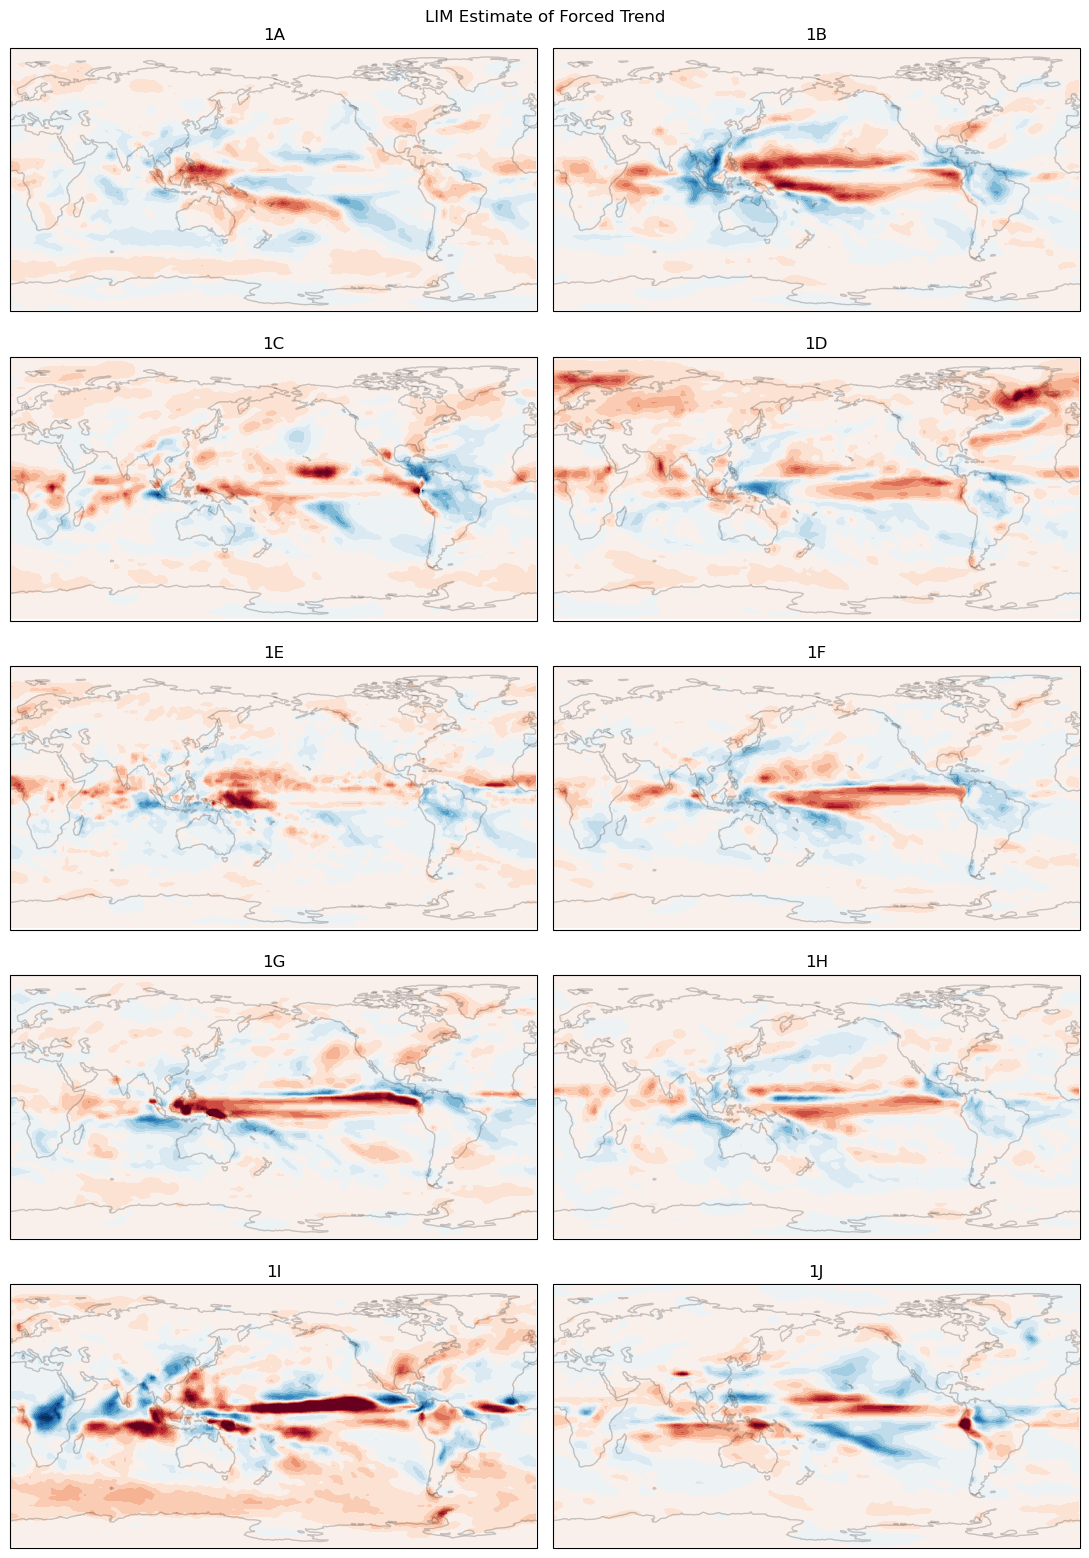

Text(0.5, 1.0, 'Forced pr (Global Mean)')

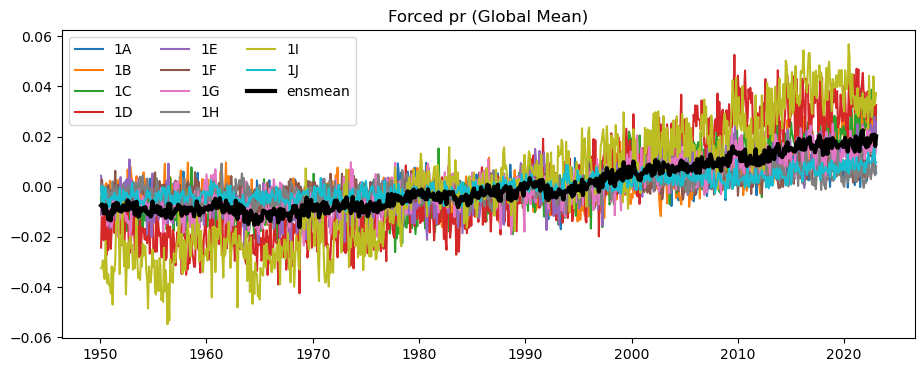

In [6]:
#####
## Target variable maxima covariance analysis [pr]
#####
# -----To be Change-----
varname = "pr" # climate field of interest
root_dir = "/glade/campaign/cgd/cas/asphilli/ForceSMIP/Evaluation-Tier1/Amon/"+varname+"/"  # path to forcesmip data (NCAR)
fname = []
for (dirpath, dirnames, fnames) in walk(root_dir):
        fname.extend(fnames)
        break
fname.sort()
savepath = '/glade/derecho/scratch/kuoyan/ForceSMIP/Tier1/Amon/'+varname+'/'

X_forced = np.empty((10,72,144)) * np.nan
X_forced_glo = np.empty((10,len(T))) * np.nan
for i in range(10):
    print(fname[i])
    ### Reading target variable
    data = ForceSMIP_read(root_dir+fname[i],varname)
    # REMOVE SEASONAL MEAN
    data["seas"],data["ano"] = ForceSMIP_removeSeas(data[varname],data["time"])
    # EOF ANALYSIS
    data2D = ForceSMIP_XYT_into_ZT(data["ano"],data["mask"])
    pca2 = ForceSMIP_EOF((data2D-np.mean(data2D))*ForceSMIP_XYT_into_ZT(np.tile(weight,(len(T),1,len(lon_axis))),data["mask"]))
    explainedVar = np.cumsum(pca2["S"][:]**2)/np.sum(pca2["S"][:]**2)
    neof = (np.abs(explainedVar - 0.9)).argmin()
    X = pca2["PC"][:,0:neof+1]
    X2 = LDM[i,:,:]
    mca = ForceSMIP_MCA(X,X2)
    mca_a = mca["MCA_A"][:,:]
    Xtrd = (mca_a[:,0:1] @ mca["MCA_Pattern_A"][0:1,:] * mca["normA"] @ np.diag(pca2["S"][0:neof+1]**2) @ pca2["EOF"][0:neof+1,:] * pca2["norm"])
    X_forced_glo[i,:] = np.mean(Xtrd,1)
    X_forced[i,:,:] = ForceSMIP_ZT_into_XYT(lintrd(T,Xtrd/ForceSMIP_XYT_into_ZT(np.tile(weight,(len(T),1,len(lon_axis))),data["mask"]))[0], data["mask"])
    Xsave = ForceSMIP_ZT_into_XYT(Xtrd/ForceSMIP_XYT_into_ZT(np.tile(weight,(len(T),1,len(lon_axis))),data["mask"]), data["mask"])
    del X, X2, mca, mca_a, neof, explainedVar, pca2, data2D, data
    
    fw = varname+'_'+ensname[i]+'_tier1_LIMnMCA_YNKuoJLien.nc'
    ncfile = nc.Dataset(savepath+fw,'w', format='NETCDF4')
    lat_dim = ncfile.createDimension('lat', 72) # latitude axis
    lon_dim = ncfile.createDimension('lon', 144) # longitude axis
    time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
    lat = ncfile.createVariable('lat',np.double,('lat',))
    lat.units = 'degrees_north'
    lat.long_name = 'latitude'

    lon = ncfile.createVariable('lon', np.double, ('lon',))
    lon.units = 'degrees_east'
    lon.long_name = 'longitude'

    time = ncfile.createVariable('time', np.float64, ('time',))
    time.units = 'days since 1850-01-01'
    time.long_name = 'time'

    pr = ncfile.createVariable('pr',np.double,('time','lat','lon')) # note: unlimited dimension is leftmost
    pr.units = 'mm/day'
    pr.standard_name = 'MCA with LIM-estimated forced tos to get forced '+varname
    lon[:] = lon_axis
    lat[:] = lat_axis
    time[:] = T4fw
    pr[:,:,:] = Xsave
    ncfile.close()
    del Xsave


clevs = np.arange(-2, 2.2, 0.2) #*100

f = plt.figure(figsize=(11, 16))
for i in range(10):
    plt.subplot(5, 2, i+1, projection=ccrs.PlateCarree(central_longitude=-180))
    im = plt.contourf(lon_axis, lat_axis, X_forced[i,:,:]*73, clevs,\
        transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, extend='both')
    # coastlines
    plt.gca().set_global()
    plt.gca().coastlines(alpha=0.2)
    plt.title(ensname[i])
    #plt.title(eval_model)
plt.suptitle('LIM Estimate of Forced Trend')
plt.tight_layout()
plt.show()

f = plt.figure(figsize=(11, 4))
for i in range(10):
    plt.plot(T,X_forced_glo[i,:],label = ensname[i])
plt.plot(T, np.mean(X_forced_glo,0), linewidth = 3, color = 'k',label = 'ensmean')
plt.legend(ncol = 3)
plt.title('Forced '+varname+' (Global Mean)')

psl_mon_1A.195001-202212.nc
psl_mon_1B.195001-202212.nc
psl_mon_1C.195001-202212.nc
psl_mon_1D.195001-202212.nc
psl_mon_1E.195001-202212.nc
psl_mon_1F.195001-202212.nc
psl_mon_1G.195001-202212.nc
psl_mon_1H.195001-202212.nc
psl_mon_1I.195001-202212.nc
psl_mon_1J.195001-202212.nc


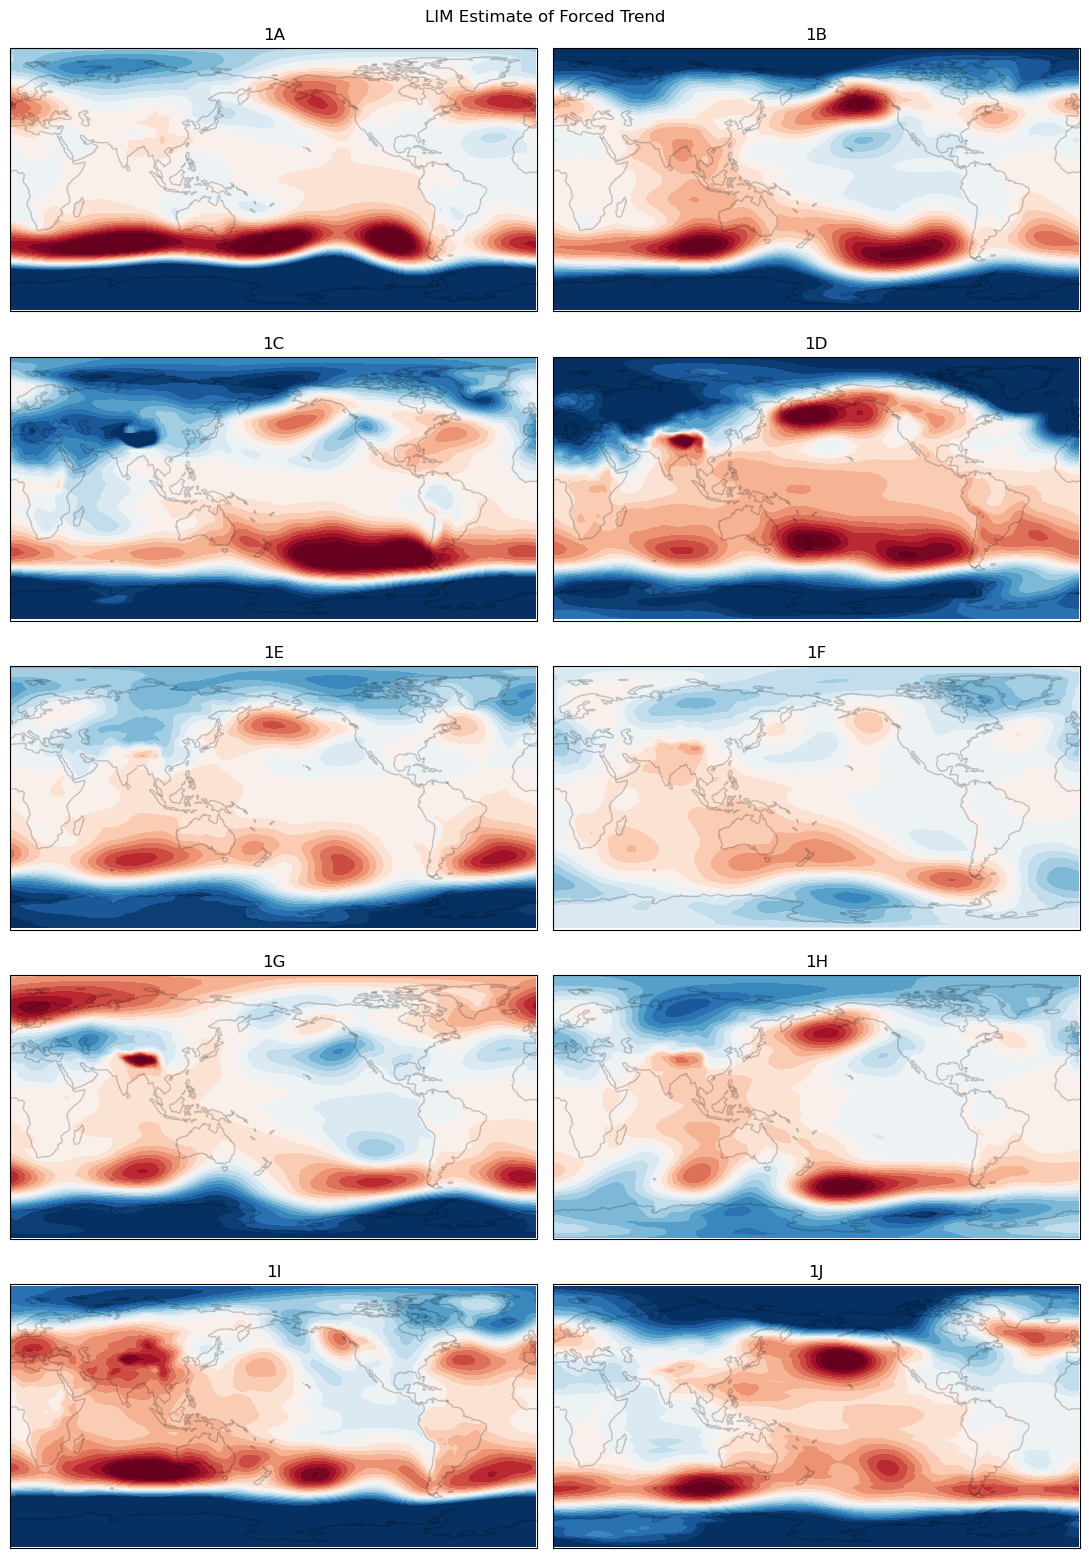

Text(0.5, 1.0, 'Forced psl (Global Mean)')

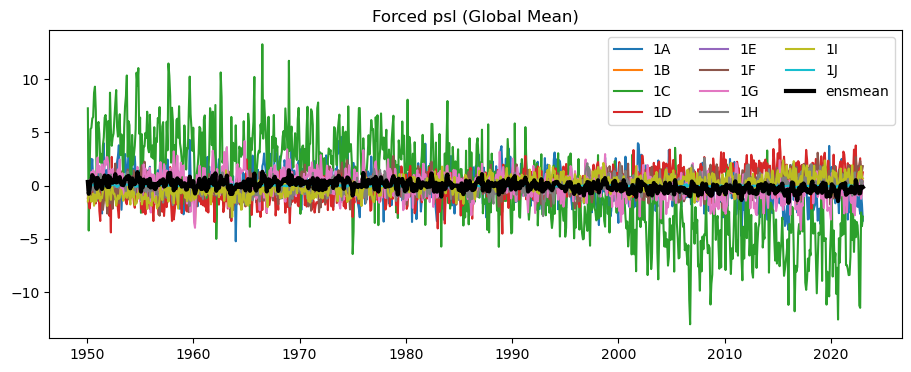

In [7]:
#####
## Target variable maxima covariance analysis [psl]
#####
# -----To be Change-----
varname = "psl" # climate field of interest
root_dir = "/glade/campaign/cgd/cas/asphilli/ForceSMIP/Evaluation-Tier1/Amon/"+varname+"/"  # path to forcesmip data (NCAR)
fname = []
for (dirpath, dirnames, fnames) in walk(root_dir):
        fname.extend(fnames)
        break
fname.sort()
savepath = '/glade/derecho/scratch/kuoyan/ForceSMIP/Tier1/Amon/'+varname+'/'

X_forced = np.empty((10,72,144)) * np.nan
X_forced_glo = np.empty((10,len(T))) * np.nan
for i in range(10):
    print(fname[i])
    ### Reading target variable
    data = ForceSMIP_read(root_dir+fname[i],varname)
    # REMOVE SEASONAL MEAN
    data["seas"],data["ano"] = ForceSMIP_removeSeas(data[varname],data["time"])
    # EOF ANALYSIS
    data2D = ForceSMIP_XYT_into_ZT(data["ano"],data["mask"])
    pca2 = ForceSMIP_EOF((data2D-np.mean(data2D))*ForceSMIP_XYT_into_ZT(np.tile(weight,(len(T),1,len(lon_axis))),data["mask"]))
    explainedVar = np.cumsum(pca2["S"][:]**2)/np.sum(pca2["S"][:]**2)
    neof = (np.abs(explainedVar - 0.9)).argmin()
    X = pca2["PC"][:,0:neof+1]
    X2 = LDM[i,:,:]
    mca = ForceSMIP_MCA(X,X2)
    mca_a = mca["MCA_A"][:,:]
    Xtrd = (mca_a[:,0:1] @ mca["MCA_Pattern_A"][0:1,:] * mca["normA"] @ np.diag(pca2["S"][0:neof+1]**2) @ pca2["EOF"][0:neof+1,:] * pca2["norm"])
    X_forced_glo[i,:] = np.mean(Xtrd,1)
    X_forced[i,:,:] = ForceSMIP_ZT_into_XYT(lintrd(T,Xtrd/ForceSMIP_XYT_into_ZT(np.tile(weight,(len(T),1,len(lon_axis))),data["mask"]))[0], data["mask"])
    Xsave = ForceSMIP_ZT_into_XYT(Xtrd/ForceSMIP_XYT_into_ZT(np.tile(weight,(len(T),1,len(lon_axis))),data["mask"]), data["mask"])
    del X, X2, mca, mca_a, neof, explainedVar, pca2, data2D, data
    
    fw = varname+'_'+ensname[i]+'_tier1_LIMnMCA_YNKuoJLien.nc'
    ncfile = nc.Dataset(savepath+fw,'w', format='NETCDF4')
    lat_dim = ncfile.createDimension('lat', 72) # latitude axis
    lon_dim = ncfile.createDimension('lon', 144) # longitude axis
    time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
    lat = ncfile.createVariable('lat',np.double,('lat',))
    lat.units = 'degrees_north'
    lat.long_name = 'latitude'

    lon = ncfile.createVariable('lon', np.double, ('lon',))
    lon.units = 'degrees_east'
    lon.long_name = 'longitude'

    time = ncfile.createVariable('time', np.float64, ('time',))
    time.units = 'days since 1850-01-01'
    time.long_name = 'time'

    psl = ncfile.createVariable('psl',np.double,('time','lat','lon')) # note: unlimited dimension is leftmost
    psl.units = 'Pa'
    psl.standard_name = 'MCA with LIM-estimated forced tos to get forced '+varname
    lon[:] = lon_axis
    lat[:] = lat_axis
    time[:] = T4fw
    psl[:,:,:] = Xsave
    ncfile.close()
    del Xsave


clevs = np.arange(-2, 2.2, 0.2)*100

f = plt.figure(figsize=(11, 16))
for i in range(10):
    plt.subplot(5, 2, i+1, projection=ccrs.PlateCarree(central_longitude=-180))
    im = plt.contourf(lon_axis, lat_axis, X_forced[i,:,:]*73, clevs,\
        transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, extend='both')
    # coastlines
    plt.gca().set_global()
    plt.gca().coastlines(alpha=0.2)
    plt.title(ensname[i])
    #plt.title(eval_model)
plt.suptitle('LIM Estimate of Forced Trend')
plt.tight_layout()
plt.show()

f = plt.figure(figsize=(11, 4))
for i in range(10):
    plt.plot(T,X_forced_glo[i,:],label = ensname[i])
plt.plot(T, np.mean(X_forced_glo,0), linewidth = 3, color = 'k',label = 'ensmean')
plt.legend(ncol = 3)
plt.title('Forced '+varname+' (Global Mean)')

monmaxtasmax_day_1A.195001-202212.nc
monmaxtasmax_day_1B.195001-202212.nc
monmaxtasmax_day_1C.195001-202212.nc
monmaxtasmax_day_1D.195001-202212.nc
monmaxtasmax_day_1E.195001-202212.nc
monmaxtasmax_day_1F.195001-202212.nc
monmaxtasmax_day_1G.195001-202212.nc
monmaxtasmax_day_1H.195001-202212.nc
monmaxtasmax_day_1I.195001-202212.nc
monmaxtasmax_day_1J.195001-202212.nc


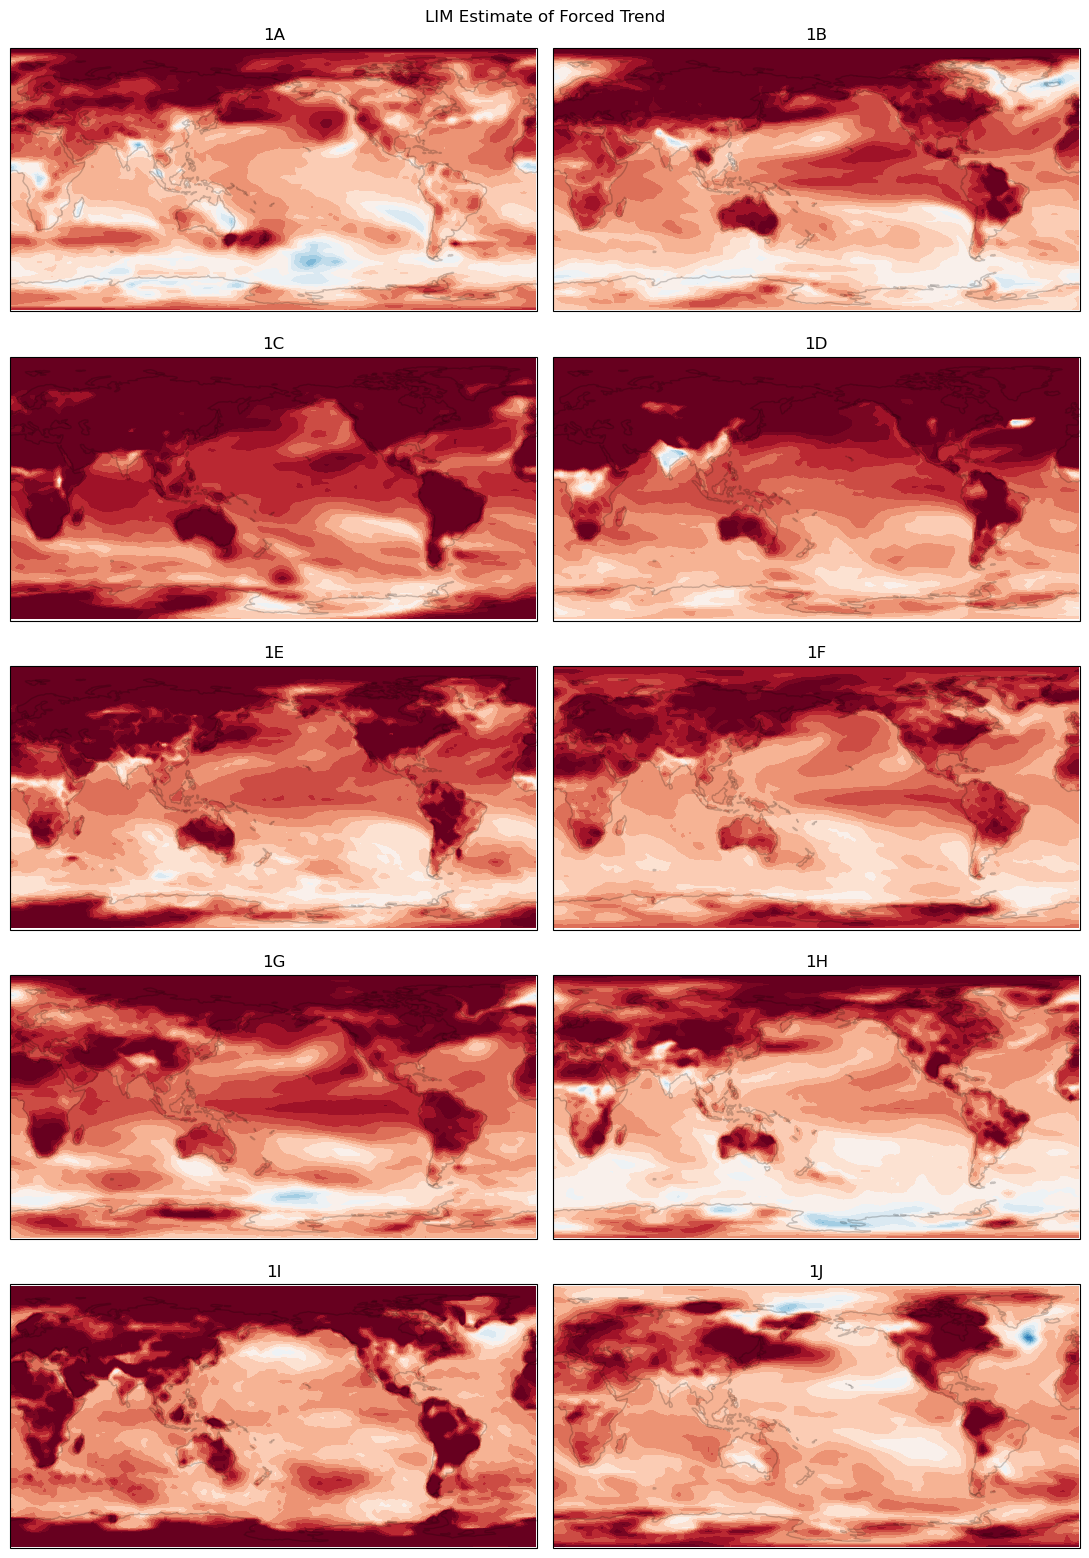

Text(0.5, 1.0, 'Forced tasmax (Global Mean)')

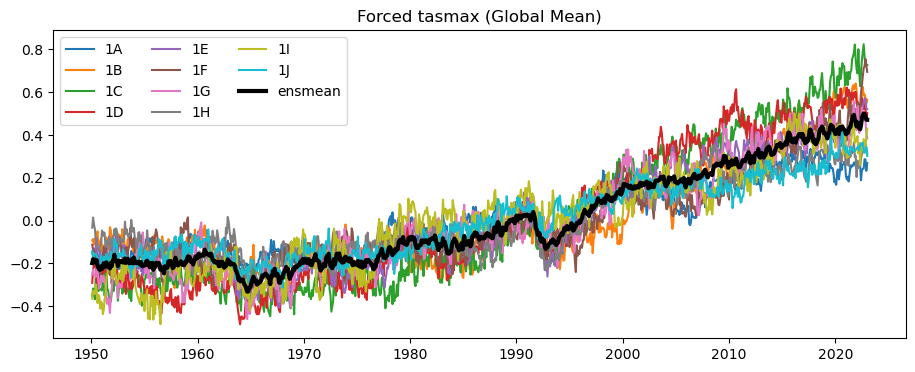

In [8]:
#####
## Target variable maxima covariance analysis [monmaxtasmax]
#####
# -----To be Change-----
varname = "tasmax" # climate field of interest
root_dir = "/glade/campaign/cgd/cas/asphilli/ForceSMIP/Evaluation-Tier1/Aday/monmax"+varname+"/"  # path to forcesmip data (NCAR)
fname = []
for (dirpath, dirnames, fnames) in walk(root_dir):
        fname.extend(fnames)
        break
fname.sort()
savepath = '/glade/derecho/scratch/kuoyan/ForceSMIP/Tier1/Aday/monmax'+varname+'/'

X_forced = np.empty((10,72,144)) * np.nan
X_forced_glo = np.empty((10,len(T))) * np.nan
for i in range(10):
    print(fname[i])
    ### Reading target variable
    data = ForceSMIP_read(root_dir+fname[i],varname)
    # REMOVE SEASONAL MEAN
    data["seas"],data["ano"] = ForceSMIP_removeSeas(data[varname],data["time"])
    # EOF ANALYSIS
    data2D = ForceSMIP_XYT_into_ZT(data["ano"],data["mask"])
    pca2 = ForceSMIP_EOF((data2D-np.mean(data2D))*ForceSMIP_XYT_into_ZT(np.tile(weight,(len(T),1,len(lon_axis))),data["mask"]))
    explainedVar = np.cumsum(pca2["S"][:]**2)/np.sum(pca2["S"][:]**2)
    neof = (np.abs(explainedVar - 0.9)).argmin()
    X = pca2["PC"][:,0:neof+1]
    X2 = LDM[i,:,:]
    mca = ForceSMIP_MCA(X,X2)
    mca_a = mca["MCA_A"][:,:]
    Xtrd = (mca_a[:,0:1] @ mca["MCA_Pattern_A"][0:1,:] * mca["normA"] @ np.diag(pca2["S"][0:neof+1]**2) @ pca2["EOF"][0:neof+1,:] * pca2["norm"])
    X_forced_glo[i,:] = np.mean(Xtrd,1)
    X_forced[i,:,:] = ForceSMIP_ZT_into_XYT(lintrd(T,Xtrd/ForceSMIP_XYT_into_ZT(np.tile(weight,(len(T),1,len(lon_axis))),data["mask"]))[0], data["mask"])
    Xsave = ForceSMIP_ZT_into_XYT(Xtrd/ForceSMIP_XYT_into_ZT(np.tile(weight,(len(T),1,len(lon_axis))),data["mask"]), data["mask"])
    del X, X2, mca, mca_a, neof, explainedVar, pca2, data2D, data
    
    fw = 'monmax'+varname+'_'+ensname[i]+'_tier1_LIMnMCA_YNKuoJLien.nc'
    ncfile = nc.Dataset(savepath+fw,'w', format='NETCDF4')
    lat_dim = ncfile.createDimension('lat', 72) # latitude axis
    lon_dim = ncfile.createDimension('lon', 144) # longitude axis
    time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
    lat = ncfile.createVariable('lat',np.double,('lat',))
    lat.units = 'degrees_north'
    lat.long_name = 'latitude'

    lon = ncfile.createVariable('lon', np.double, ('lon',))
    lon.units = 'degrees_east'
    lon.long_name = 'longitude'

    time = ncfile.createVariable('time', np.float64, ('time',))
    time.units = 'days since 1850-01-01'
    time.long_name = 'time'

    tasmax = ncfile.createVariable('tasmax',np.double,('time','lat','lon')) # note: unlimited dimension is leftmost
    tasmax.units = 'K'
    tasmax.standard_name = 'MCA with LIM-estimated forced tos to get forced '+varname
    lon[:] = lon_axis
    lat[:] = lat_axis
    time[:] = T4fw
    tasmax[:,:,:] = Xsave
    ncfile.close()
    del Xsave


clevs = np.arange(-2, 2.2, 0.2) #*100

f = plt.figure(figsize=(11, 16))
for i in range(10):
    plt.subplot(5, 2, i+1, projection=ccrs.PlateCarree(central_longitude=-180))
    im = plt.contourf(lon_axis, lat_axis, X_forced[i,:,:]*73, clevs,\
        transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, extend='both')
    # coastlines
    plt.gca().set_global()
    plt.gca().coastlines(alpha=0.2)
    plt.title(ensname[i])
    #plt.title(eval_model)
plt.suptitle('LIM Estimate of Forced Trend')
plt.tight_layout()
plt.show()

f = plt.figure(figsize=(11, 4))
for i in range(10):
    plt.plot(T,X_forced_glo[i,:],label = ensname[i])
plt.plot(T, np.mean(X_forced_glo,0), linewidth = 3, color = 'k',label = 'ensmean')
plt.legend(ncol = 3)
plt.title('Forced '+varname+' (Global Mean)')

/glade/derecho/scratch/kuoyan/tmp/ipykernel_57812/2693697069.py:15: RuntimeWarning: invalid value encountered in multiply
  X_forced_glo = np.empty((10,len(T))) * np.nan


monmintasmin_day_1A.195001-202212.nc
monmintasmin_day_1B.195001-202212.nc
monmintasmin_day_1C.195001-202212.nc
monmintasmin_day_1D.195001-202212.nc
monmintasmin_day_1E.195001-202212.nc
monmintasmin_day_1F.195001-202212.nc
monmintasmin_day_1G.195001-202212.nc
monmintasmin_day_1H.195001-202212.nc
monmintasmin_day_1I.195001-202212.nc
monmintasmin_day_1J.195001-202212.nc


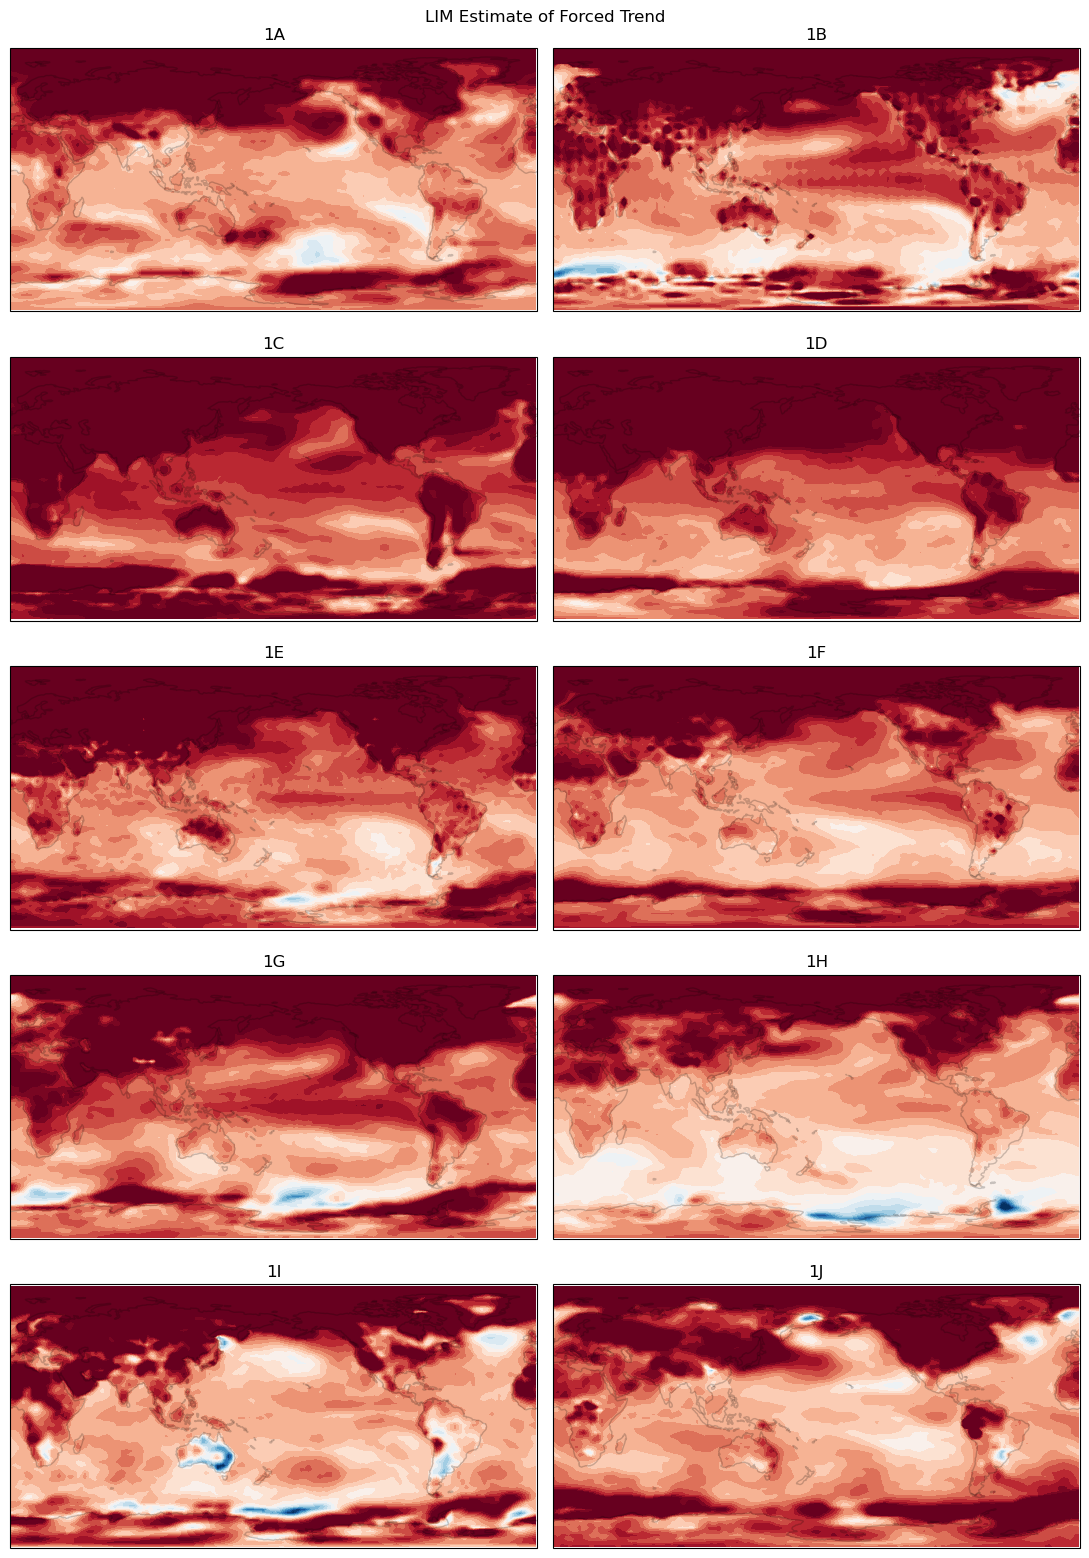

Text(0.5, 1.0, 'Forced tasmin (Global Mean)')

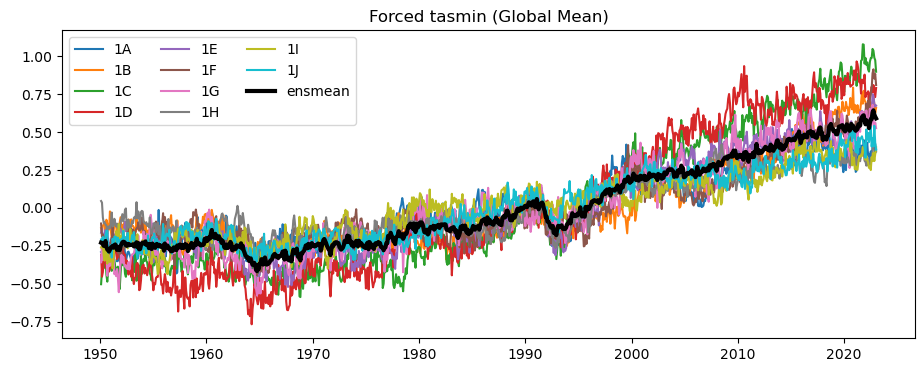

In [9]:
#####
## Target variable maxima covariance analysis [monmintasmin]
#####
# -----To be Change-----
varname = "tasmin" # climate field of interest
root_dir = "/glade/campaign/cgd/cas/asphilli/ForceSMIP/Evaluation-Tier1/Aday/monmin"+varname+"/"  # path to forcesmip data (NCAR)
fname = []
for (dirpath, dirnames, fnames) in walk(root_dir):
        fname.extend(fnames)
        break
fname.sort()
savepath = '/glade/derecho/scratch/kuoyan/ForceSMIP/Tier1/Aday/monmin'+varname+'/'

X_forced = np.empty((10,72,144)) * np.nan
X_forced_glo = np.empty((10,len(T))) * np.nan
for i in range(10):
    print(fname[i])
    ### Reading target variable
    data = ForceSMIP_read(root_dir+fname[i],varname)
    # REMOVE SEASONAL MEAN
    data["seas"],data["ano"] = ForceSMIP_removeSeas(data[varname],data["time"])
    # EOF ANALYSIS
    data2D = ForceSMIP_XYT_into_ZT(data["ano"],data["mask"])
    pca2 = ForceSMIP_EOF((data2D-np.mean(data2D))*ForceSMIP_XYT_into_ZT(np.tile(weight,(len(T),1,len(lon_axis))),data["mask"]))
    explainedVar = np.cumsum(pca2["S"][:]**2)/np.sum(pca2["S"][:]**2)
    neof = (np.abs(explainedVar - 0.9)).argmin()
    X = pca2["PC"][:,0:neof+1]
    X2 = LDM[i,:,:]
    mca = ForceSMIP_MCA(X,X2)
    mca_a = mca["MCA_A"][:,:]
    Xtrd = (mca_a[:,0:1] @ mca["MCA_Pattern_A"][0:1,:] * mca["normA"] @ np.diag(pca2["S"][0:neof+1]**2) @ pca2["EOF"][0:neof+1,:] * pca2["norm"])
    X_forced_glo[i,:] = np.mean(Xtrd,1)
    X_forced[i,:,:] = ForceSMIP_ZT_into_XYT(lintrd(T,Xtrd/ForceSMIP_XYT_into_ZT(np.tile(weight,(len(T),1,len(lon_axis))),data["mask"]))[0], data["mask"])
    Xsave = ForceSMIP_ZT_into_XYT(Xtrd/ForceSMIP_XYT_into_ZT(np.tile(weight,(len(T),1,len(lon_axis))),data["mask"]), data["mask"])
    del X, X2, mca, mca_a, neof, explainedVar, pca2, data2D, data
    
    fw = 'monmin'+varname+'_'+ensname[i]+'_tier1_LIMnMCA_YNKuoJLien.nc'
    ncfile = nc.Dataset(savepath+fw,'w', format='NETCDF4')
    lat_dim = ncfile.createDimension('lat', 72) # latitude axis
    lon_dim = ncfile.createDimension('lon', 144) # longitude axis
    time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
    lat = ncfile.createVariable('lat',np.double,('lat',))
    lat.units = 'degrees_north'
    lat.long_name = 'latitude'

    lon = ncfile.createVariable('lon', np.double, ('lon',))
    lon.units = 'degrees_east'
    lon.long_name = 'longitude'

    time = ncfile.createVariable('time', np.float64, ('time',))
    time.units = 'days since 1850-01-01'
    time.long_name = 'time'

    tasmin = ncfile.createVariable('tasmin',np.double,('time','lat','lon')) # note: unlimited dimension is leftmost
    tasmin.units = 'K'
    tasmin.standard_name = 'MCA with LIM-estimated forced tos to get forced '+varname
    lon[:] = lon_axis
    lat[:] = lat_axis
    time[:] = T4fw
    tasmin[:,:,:] = Xsave
    ncfile.close()
    del Xsave


clevs = np.arange(-2, 2.2, 0.2) #*100

f = plt.figure(figsize=(11, 16))
for i in range(10):
    plt.subplot(5, 2, i+1, projection=ccrs.PlateCarree(central_longitude=-180))
    im = plt.contourf(lon_axis, lat_axis, X_forced[i,:,:]*73, clevs,\
        transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, extend='both')
    # coastlines
    plt.gca().set_global()
    plt.gca().coastlines(alpha=0.2)
    plt.title(ensname[i])
    #plt.title(eval_model)
plt.suptitle('LIM Estimate of Forced Trend')
plt.tight_layout()
plt.show()

f = plt.figure(figsize=(11, 4))
for i in range(10):
    plt.plot(T,X_forced_glo[i,:],label = ensname[i])
plt.plot(T, np.mean(X_forced_glo,0), linewidth = 3, color = 'k',label = 'ensmean')
plt.legend(ncol = 3)
plt.title('Forced '+varname+' (Global Mean)')

monmaxpr_day_1A.195001-202212.nc
monmaxpr_day_1B.195001-202212.nc
monmaxpr_day_1C.195001-202212.nc
monmaxpr_day_1D.195001-202212.nc
monmaxpr_day_1E.195001-202212.nc
monmaxpr_day_1F.195001-202212.nc
monmaxpr_day_1G.195001-202212.nc
monmaxpr_day_1H.195001-202212.nc
monmaxpr_day_1I.195001-202212.nc
monmaxpr_day_1J.195001-202212.nc


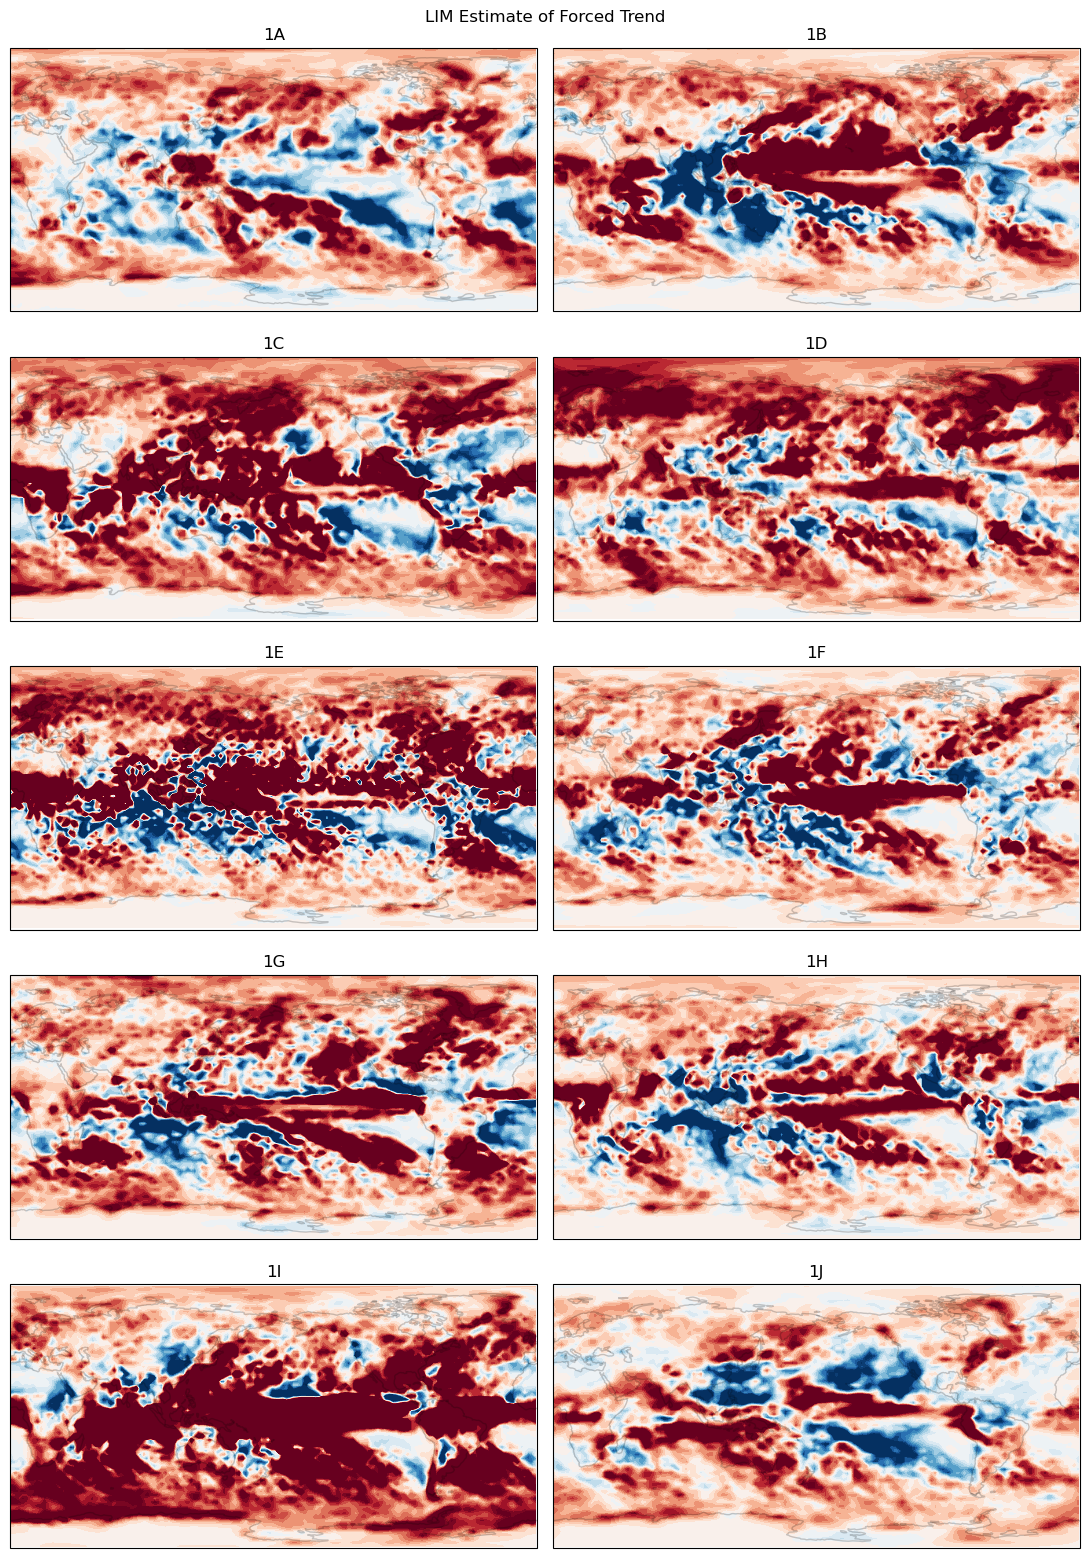

Text(0.5, 1.0, 'Forced pr (Global Mean)')

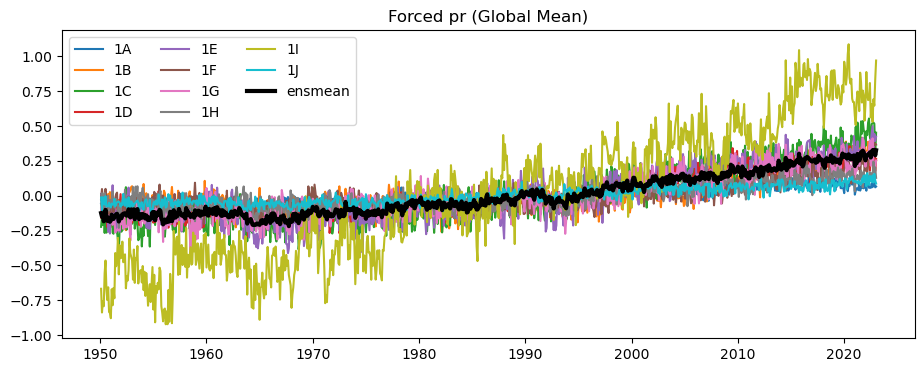

In [18]:
#####
## Target variable maxima covariance analysis [mommaxpr]
#####
# -----To be Change-----
varname = "pr" # climate field of interest
root_dir = "/glade/campaign/cgd/cas/asphilli/ForceSMIP/Evaluation-Tier1/Aday/monmax"+varname+"/"  # path to forcesmip data (NCAR)
fname = []
for (dirpath, dirnames, fnames) in walk(root_dir):
        fname.extend(fnames)
        break
fname.sort()
savepath = '/glade/derecho/scratch/kuoyan/ForceSMIP/Tier1/Aday/monmax'+varname+'/'

X_forced = np.empty((10,72,144)) * np.nan
X_forced_glo = np.empty((10,len(T))) * np.nan
for i in range(10):
    print(fname[i])
    ### Reading target variable
    data = ForceSMIP_read(root_dir+fname[i],varname)
    # REMOVE SEASONAL MEAN
    data["seas"],data["ano"] = ForceSMIP_removeSeas(data[varname],data["time"])
    # EOF ANALYSIS
    data2D = ForceSMIP_XYT_into_ZT(data["ano"],data["mask"])
    pca2 = ForceSMIP_EOF((data2D-np.mean(data2D))*ForceSMIP_XYT_into_ZT(np.tile(weight,(len(T),1,len(lon_axis))),data["mask"]))
    explainedVar = np.cumsum(pca2["S"][:]**2)/np.sum(pca2["S"][:]**2)
    neof = (np.abs(explainedVar - 0.9)).argmin()
    X = pca2["PC"][:,0:neof+1]
    X2 = LDM[i,:,:]
    mca = ForceSMIP_MCA(X,X2)
    mca_a = mca["MCA_A"][:,:]
    Xtrd = (mca_a[:,0:1] @ mca["MCA_Pattern_A"][0:1,:] * mca["normA"] @ np.diag(pca2["S"][0:neof+1]**2) @ pca2["EOF"][0:neof+1,:] * pca2["norm"])
    X_forced_glo[i,:] = np.mean(Xtrd,1)
    X_forced[i,:,:] = ForceSMIP_ZT_into_XYT(lintrd(T,Xtrd/ForceSMIP_XYT_into_ZT(np.tile(weight,(len(T),1,len(lon_axis))),data["mask"]))[0], data["mask"])
    Xsave = ForceSMIP_ZT_into_XYT(Xtrd/ForceSMIP_XYT_into_ZT(np.tile(weight,(len(T),1,len(lon_axis))),data["mask"]), data["mask"])
    del X, X2, mca, mca_a, neof, explainedVar, pca2, data2D, data
    
    fw = 'monmax'+varname+'_'+ensname[i]+'_tier1_LIMnMCA_YNKuoJLien.nc'
    ncfile = nc.Dataset(savepath+fw,'w', format='NETCDF4')
    lat_dim = ncfile.createDimension('lat', 72) # latitude axis
    lon_dim = ncfile.createDimension('lon', 144) # longitude axis
    time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
    lat = ncfile.createVariable('lat',np.double,('lat',))
    lat.units = 'degrees_north'
    lat.long_name = 'latitude'

    lon = ncfile.createVariable('lon', np.double, ('lon',))
    lon.units = 'degrees_east'
    lon.long_name = 'longitude'

    time = ncfile.createVariable('time', np.float64, ('time',))
    time.units = 'days since 1850-01-01'
    time.long_name = 'time'

    pr = ncfile.createVariable('pr',np.double,('time','lat','lon')) # note: unlimited dimension is leftmost
    pr.units = 'mm/day'
    pr.standard_name = 'MCA with LIM-estimated forced tos to get forced monmax'+varname
    lon[:] = lon_axis
    lat[:] = lat_axis
    time[:] = T4fw
    pr[:,:,:] = Xsave
    ncfile.close()
    del Xsave


clevs = np.arange(-2, 2.2, 0.2) #*100

f = plt.figure(figsize=(11, 16))
for i in range(10):
    plt.subplot(5, 2, i+1, projection=ccrs.PlateCarree(central_longitude=-180))
    im = plt.contourf(lon_axis, lat_axis, X_forced[i,:,:]*73, clevs,\
        transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r, extend='both')
    # coastlines
    plt.gca().set_global()
    plt.gca().coastlines(alpha=0.2)
    plt.title(ensname[i])
    #plt.title(eval_model)
plt.suptitle('LIM Estimate of Forced Trend')
plt.tight_layout()
plt.show()

f = plt.figure(figsize=(11, 4))
for i in range(10):
    plt.plot(T,X_forced_glo[i,:],label = ensname[i])
plt.plot(T, np.mean(X_forced_glo,0), linewidth = 3, color = 'k',label = 'ensmean')
plt.legend(ncol = 3)
plt.title('Forced '+varname+' (Global Mean)')


zmta_mon_1A.195001-202212.nc
zmta_mon_1B.195001-202212.nc
zmta_mon_1C.195001-202212.nc
zmta_mon_1D.195001-202212.nc
zmta_mon_1E.195001-202212.nc
zmta_mon_1F.195001-202212.nc
zmta_mon_1G.195001-202212.nc
zmta_mon_1H.195001-202212.nc
zmta_mon_1I.195001-202212.nc
zmta_mon_1J.195001-202212.nc


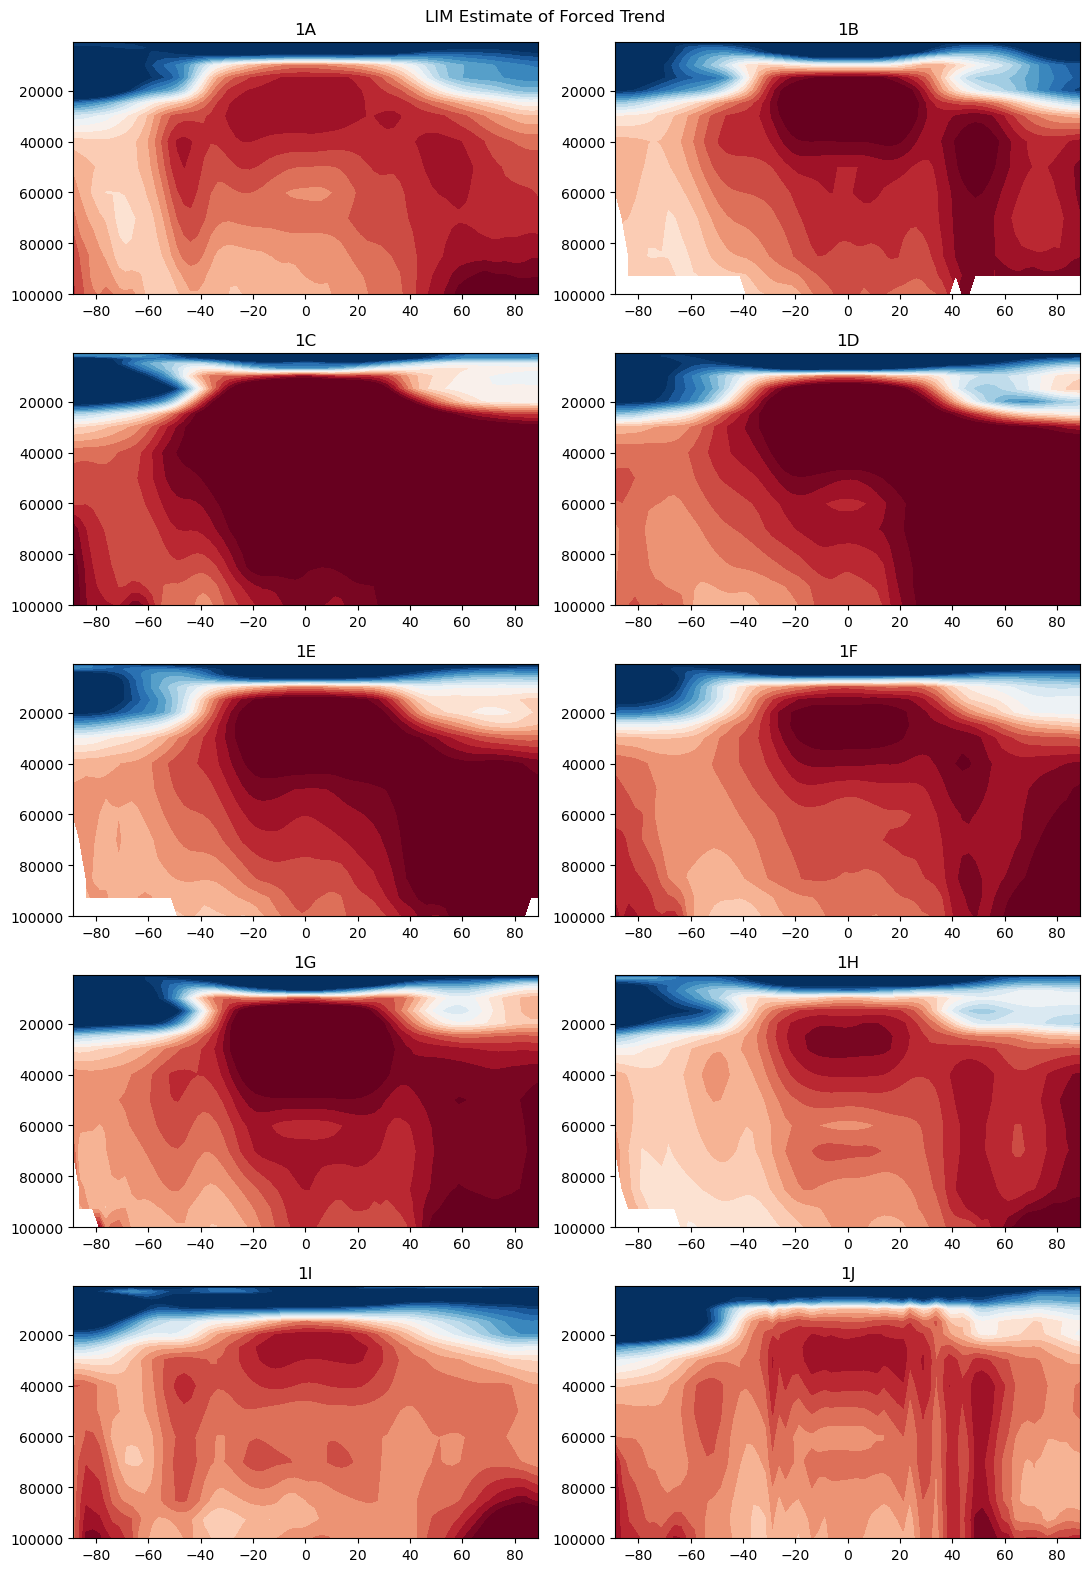

Text(0.5, 1.0, 'Forced ta (Global Mean)')

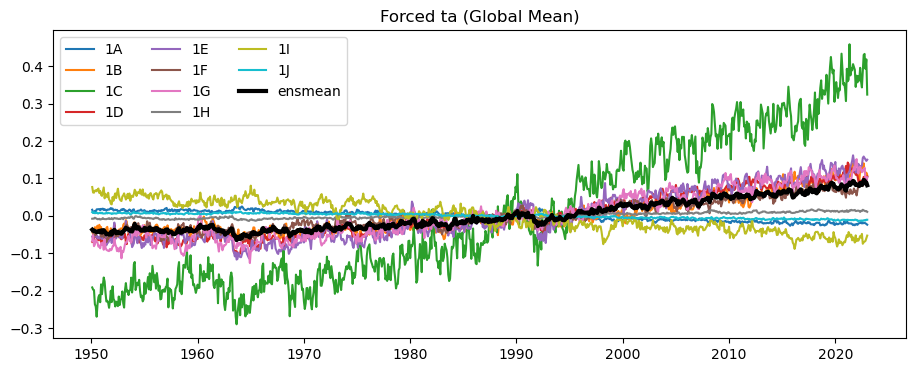

In [18]:
#####
## Target variable maxima covariance analysis [zmta]
#####
# -----To be Change-----
varname = "ta" # climate field of interest
root_dir = "/glade/campaign/cgd/cas/asphilli/ForceSMIP/Evaluation-Tier1/Amon/zm"+varname+"/"  # path to forcesmip data (NCAR)
fname = []
for (dirpath, dirnames, fnames) in walk(root_dir):
        fname.extend(fnames)
        break
fname.sort()
savepath = '/glade/derecho/scratch/kuoyan/ForceSMIP/Tier1/Amon/zm'+varname+'/'
weight4zmta = np.empty((1,1,72)) * np.nan
weight4zmta[0,0,:] = weight[0,:,0]
X_forced = np.empty((10,17,72)) * np.nan
X_forced_glo = np.empty((10,len(T))) * np.nan
for i in range(10):
    print(fname[i])
    ### Reading target variable
    data = ForceSMIP_read_zmta(root_dir+fname[i],varname)
    plev_zmta = data["plev_axis"]
    lat_zmta = data["lat_axis"]
    # REMOVE SEASONAL MEAN
    data["seas"],data["ano"] = ForceSMIP_removeSeas(data[varname],data["time"])
    # EOF ANALYSIS
    data2D = ForceSMIP_XYT_into_ZT(data["ano"],data["mask"])
    pca2 = ForceSMIP_EOF((data2D-np.mean(data2D))*ForceSMIP_XYT_into_ZT(np.tile(weight4zmta,(len(T),17,1)),data["mask"]))
    explainedVar = np.cumsum(pca2["S"][:]**2)/np.sum(pca2["S"][:]**2)
    neof = (np.abs(explainedVar - 0.9)).argmin()
    X = pca2["PC"][:,0:neof+1]
    X2 = LDM[i,:,:]
    mca = ForceSMIP_MCA(X,X2)
    mca_a = mca["MCA_A"][:,:]
    Xtrd = (mca_a[:,0:1] @ mca["MCA_Pattern_A"][0:1,:] * mca["normA"] @ np.diag(pca2["S"][0:neof+1]**2) @ pca2["EOF"][0:neof+1,:] * pca2["norm"])
    X_forced_glo[i,:] = np.mean(Xtrd,1)
    X_forced[i,:,:] = ForceSMIP_ZT_into_XYT(lintrd(T,Xtrd/ForceSMIP_XYT_into_ZT(np.tile(weight4zmta,(len(T),17,1)),data["mask"]))[0], data["mask"])
    Xsave = ForceSMIP_ZT_into_XYT(Xtrd/ForceSMIP_XYT_into_ZT(np.tile(weight4zmta,(len(T),17,1)),data["mask"]), data["mask"])
    del X, X2, mca, mca_a, neof, explainedVar, pca2, data2D, data
 
    fw = 'zm'+varname+'_'+ensname[i]+'_tier1_LIMnMCA_YNKuoJLien.nc'
    ncfile = nc.Dataset(savepath+fw,'w', format='NETCDF4')
    lat_dim = ncfile.createDimension('lat', 72) # latitude axis
    plev_dim = ncfile.createDimension('plev', 17) # longitude axis
    time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
    lat = ncfile.createVariable('lat',np.double,('lat',))
    lat.units = 'degrees_north'
    lat.long_name = 'latitude'

    plev = ncfile.createVariable('plev', np.double, ('plev',))
    plev.units = 'Pa'
    plev.long_name = 'pressure'

    time = ncfile.createVariable('time', np.float64, ('time',))
    time.units = 'days since 1850-01-01'
    time.long_name = 'time'

    ta = ncfile.createVariable('ta',np.double,('time','plev','lat')) # note: unlimited dimension is leftmost
    ta.units = 'K'
    ta.standard_name = 'MCA with LIM-estimated forced tos to get forced zm'+varname
    plev[:] = plev_zmta
    lat[:] = lat_zmta
    time[:] = T4fw
    ta[:,:,:] = Xsave
    ncfile.close()
    del Xsave


clevs = np.arange(-2, 2.2, 0.2) #*100

f = plt.figure(figsize=(11, 16))
for i in range(10):
    plt.subplot(5, 2, i+1)
    im = plt.contourf(lat_zmta,plev_zmta, X_forced[i,:,:]*73, clevs,\
        cmap=plt.cm.RdBu_r, extend='both')
    plt.title(ensname[i])
    plt.gca().invert_yaxis()
    #plt.title(eval_model)
plt.suptitle('LIM Estimate of Forced Trend')
plt.tight_layout()
plt.show()

f = plt.figure(figsize=(11, 4))
for i in range(10):
    plt.plot(T,X_forced_glo[i,:],label = ensname[i])
plt.plot(T, np.mean(X_forced_glo,0), linewidth = 3, color = 'k',label = 'ensmean')
plt.legend(ncol = 3)
plt.title('Forced '+varname+' (Global Mean)')